In [2]:
# Loan Approval Prediction - Notebook 02: Model Training
# Updated for the dataset containing columns such as person_age, person_income, credit_score, etc.

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load cleaned data
df = pd.read_csv('data/processed/cleaned_loan_data.csv')
print("Shape:", df.shape)
df.head()


Shape: (45000, 17)


,person_age,Gender,Education,ApplicantIncome,Employment_Experience,Home_Ownership,LoanAmount,Loan_Purpose,Interest_Rate,Loan_Income_Percent,Credit_History_Length,Credit_Score,Previous_Default,Loan_Status,Income_to_Loan_Ratio,Age_Group,Credit_Rating
0,22.0,Female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,NaN,1,2.055598,18-30,Poor
1,21.0,Female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,NaN,0,12.269730,18-30,Poor
2,25.0,Female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,NaN,1,2.261043,18-30,Fair
3,23.0,Female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,NaN,1,2.278592,18-30,Fair
4,24.0,Male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,NaN,1,1.889517,18-30,Poor


In [4]:
# Check target balance
df['Loan_Status'].value_counts(normalize=True)


Loan_Status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

In [5]:
# Define target and features
y = df['Loan_Status']
X = df.drop(columns=['Loan_Status'])


In [6]:
# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['Gender', 'Education', 'Home_Ownership', 'Loan_Purpose', 'Age_Group', 'Credit_Rating']
Numeric columns: ['person_age', 'ApplicantIncome', 'Employment_Experience', 'LoanAmount', 'Interest_Rate', 'Loan_Income_Percent', 'Credit_History_Length', 'Credit_Score', 'Previous_Default', 'Income_to_Loan_Ratio']


In [ ]:
# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (36000, 16)
Test shape: (9000, 16)


In [9]:
# RandomForest Classifier
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=None
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7000
           1       0.92      0.65      0.76      2000

    accuracy                           0.91      9000
   macro avg       0.91      0.82      0.85      9000
weighted avg       0.91      0.91      0.90      9000

RandomForest ROC-AUC: 0.9238359642857142


In [10]:
# XGBoost Classifier
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7000
           1       0.92      0.66      0.77      2000

    accuracy                           0.91      9000
   macro avg       0.91      0.82      0.86      9000
weighted avg       0.91      0.91      0.91      9000

XGBoost ROC-AUC: 0.9293704642857142


In [11]:
# Compare model performances
results = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})
results.sort_values(by='ROC-AUC', ascending=False)


,Model,ROC-AUC
1,XGBoost,0.929370
0,RandomForest,0.923836


In [12]:
# Select best model
best_model_name = results.loc[results['ROC-AUC'].idxmax(), 'Model']
if best_model_name == 'RandomForest':
    best_model = rf_pipeline
else:
    best_model = xgb_pipeline

print("Selected model:", best_model_name)


Selected model: XGBoost


In [14]:
# Save the best model
joblib.dump(best_model, 'models/best_model.joblib')
print("Model saved to models/best_model.joblib")


Model saved to models/best_model.joblib


In [34]:
# Generate SHAP explainability using TreeExplainer
# Use the fitted preprocessor and model inside the trained pipeline

fitted_preprocessor = best_model.named_steps['preprocess']
model_estimator = best_model.named_steps['model']

# Transform training data using the fitted preprocessor
X_transformed = fitted_preprocessor.transform(X_train)

# Automatically get correct feature names from the fitted ColumnTransformer
feature_names = fitted_preprocessor.get_feature_names_out()

# Confirm the shape and name count match
print("Transformed shape:", X_transformed.shape)
print("Number of feature names:", len(feature_names))

Transformed shape: (36000, 35)
Number of feature names: 35


Switching to RandomForest for SHAP to avoid XGBoost parsing issue.


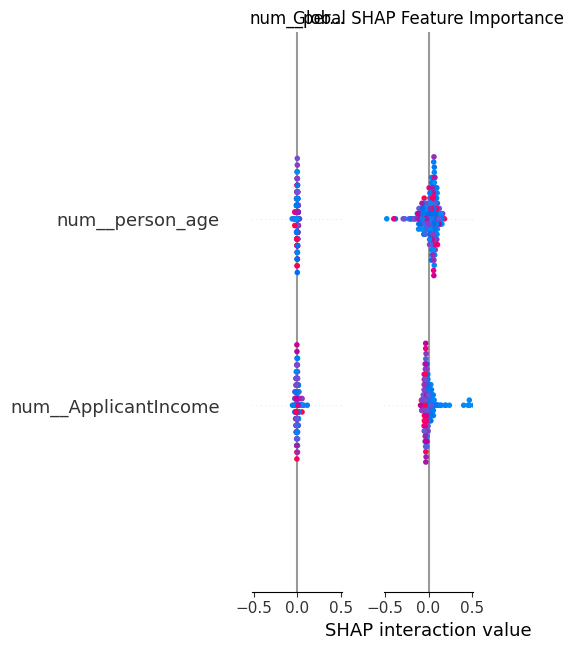

In [38]:
# Create DataFrame with consistent shape and column names
X_bg = pd.DataFrame(X_transformed, columns=feature_names)

# Take a subset for SHAP (to speed up computation)
X_sample = X_bg.sample(200, random_state=42)

if "XGB" in type(model_estimator).__name__:
    print("Switching to RandomForest for SHAP to avoid XGBoost parsing issue.")
    rf_est = rf_pipeline.named_steps['model']
    model_estimator = rf_est
# Build SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model_estimator)
shap_values = explainer.shap_values(X_sample)



<Figure size 1000x600 with 0 Axes>

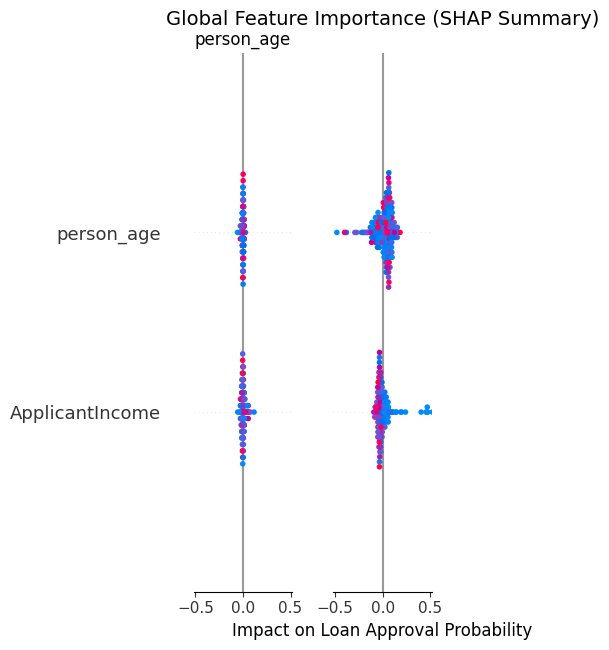

In [49]:
plt.figure(figsize=(10, 6))
clean_feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
X_sample.columns = clean_feature_names

shap.summary_plot(shap_values, X_sample, feature_names=clean_feature_names, show=False)
plt.title("Global Feature Importance (SHAP Summary)", fontsize=14, pad=20)
plt.xlabel("Impact on Loan Approval Probability", fontsize=12)
plt.tight_layout()
plt.savefig('models/shap_summary_clean.png', dpi=300, bbox_inches='tight')
plt.show()

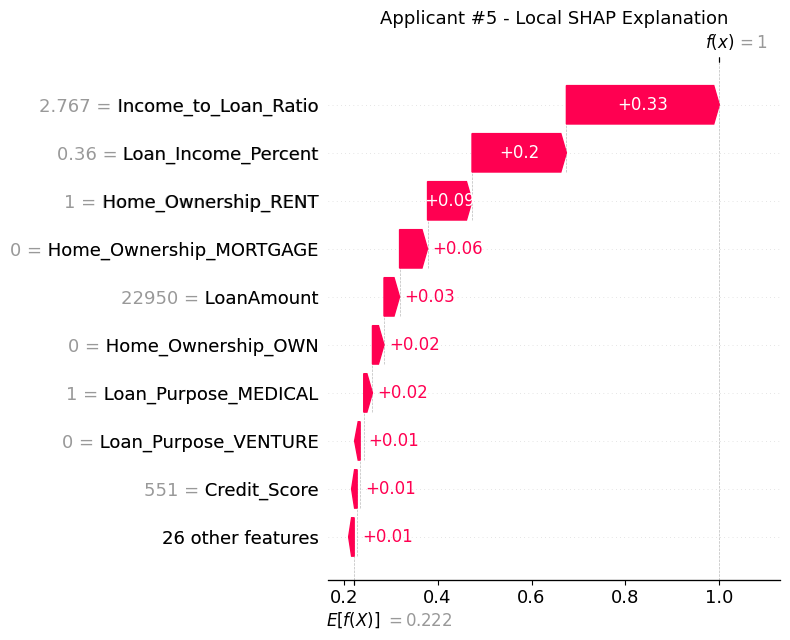

In [57]:
# Local explanation for one applicant
idx = 5
X_one = X_sample.iloc[[idx]].copy()
X_one.columns = [c.replace('num__', '').replace('cat__', '') for c in X_one.columns]

shap_vals = explainer(X_one)
vals = shap_vals.values[0, :, 1] if shap_vals.values.ndim == 3 else shap_vals.values[0]
base = shap_vals.base_values[0, 1] if np.ndim(shap_vals.base_values) > 1 else shap_vals.base_values[0]

expl = shap.Explanation(values=vals, base_values=base, data=X_one.iloc[0], feature_names=X_one.columns)

shap.plots.waterfall(expl, max_display=10, show=False)
plt.title(f"Applicant #{idx} - Local SHAP Explanation", fontsize=13)
plt.tight_layout()
plt.savefig(f'models/shap_waterfall_{idx}.png', dpi=300, bbox_inches='tight')
plt.show()


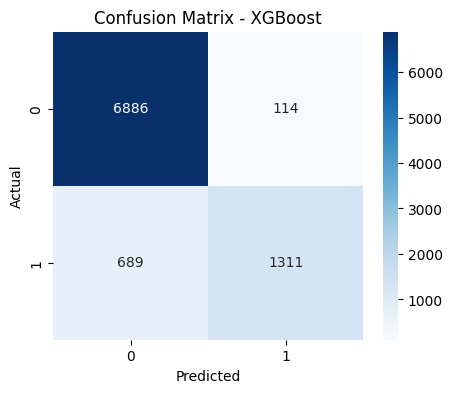

In [58]:
# Confusion Matrix for visual evaluation
y_pred_final = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [59]:
# Save background data for Streamlit SHAP plots
X_sample.head(100).to_csv('data/processed/background_shap.csv', index=False)
print("Background SHAP data saved to data/processed/background_shap.csv")


Background SHAP data saved to data/processed/background_shap.csv
